#  A/B Test 
##### Compare between new and old versions of a website to see if the new version is doing better or not.
--------------------------------------------------------------



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part v - Conclusions](#Conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. The number of unique users in the dataset.

In [4]:
print(str(df.shape[0]) + ' Size of Dataset')
print(str(len(df.user_id.unique()))+' Unique rows')

294478 Size of Dataset
290584 Unique rows


d. The proportion of users converted.

In [5]:
df.query("converted == 1").shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("group == 'control' and landing_page=='new_page'").shape[0]+df.query("group == 'treatment' and landing_page=='old_page'").shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

The best scenario here is to exclude these records that do not match so we are sure of our result

a. Now we will create a new dataset that meets the specifications.  Store the new dataframe in **df2**.

In [8]:
df_first = df.query("group == 'treatment' and landing_page=='new_page'")
df_second = df.query("group == 'control' and landing_page=='old_page'")

In [9]:
df2 = df_first.append(df_second)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to make sure of accuracy

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.shape[0]

290585

In [12]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(2893,axis=0,inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.query("converted == 1").shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
prob_of_original_control = df2.query("group=='control'and converted == 1 ").shape[0]/ df2.query("group=='control'").shape[0]
prob_of_original_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
prob_of_original_treatment = df2.query("group=='treatment'and converted == 1 ").shape[0]/ df2.query("group=='treatment'").shape[0]
prob_of_original_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query("landing_page == 'new_page'").shape[0]/df2.shape[0]

0.5000619442226688

e. Considering the results from parts (a) through (d) above, there is not sufficient evidence to conclude that the new treatment page leads to more conversions as the old page has a conversion rate higher than the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null and Alternative hypothesis**
 
 <span style="color:white">asdasdasdasdasdadasasdasdasdasdasdsadasdsadasdasdas</span>  **$H_0$** : **$p_{new}$** - **$p_{old}$** **$\le$** 0
 
 <span style="color:white">asdasdasdasdasdadasasdasdasdasdasdsadasdsadasdasdas</span>  **$H_1$** : **$p_{new}$** - **$p_{old}$** **$>$** 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [20]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2.query("converted==1").shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2.query("group=='treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query("group=='control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted

array([1, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.00038746769673883574

In [28]:
# Create a tratment and control dataframe
control_df = df2.query("group=='control'")
treatment_df = df2.query("group=='treatment'")

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

### <span style="color:red">WARNING</span>
The following cell shows the proper way to do a bootstrapping and sample distribution but due to a large amount of data and 
the large number of iterations, it will take a quite long time to run!
so you can ignore the following cell and run the one after it(will take much less time) and it will give you the same result. 

In [29]:
# YOU CAN IGNORE THIS CELL
# bootstrapping to get the sampling distribution of the conversion differences
control_conv_prob = []
treatment_conv_prob = []
diffs = []

# for loops are much slower than numpy functions
for _ in range(10000):
    sample_old2 = control_df.sample(n_old, replace=True)
    sample_new2 = treatment_df.sample(n_new, replace=True)

    control_conversion = sample_old2['converted'].sum() / n_old
    treatment_conversion = sample_new2['converted'].sum() / n_new

# Also numpy binomial function would generate the distribution given that the null is true
#control_conversion = np.random.binomial(n_old, p_old, 10000) / n_old
#treatment_conversion = np.random.binomial(n_new, p_new, 10000) / n_new
    
    control_conv_prob.append(control_conversion)
    treatment_conv_prob.append(treatment_conversion)
    diffs.append(treatment_conversion - control_conversion)
    
diffs = np.array(diffs)

In [30]:
################# IF YOU IGNORED THE PREVIOUS CELL REMOVE THE # MARK FROM THE CODE AND RUN THE CELL
# simulation_of_new = np.random.binomial(n_new,p_new,10000)/n_new
# simulation_of_old = np.random.binomial(n_old,p_old,10000)/n_old
# p_diffs = simulation_of_new - simulation_of_old

In [33]:
# simulatinf distribution under the null 
# RUN THIS IF YOU FOLLOW THE BOOTSTRAPING
p_diffs = np.random.normal(0,diffs.std(),diffs.size)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? 

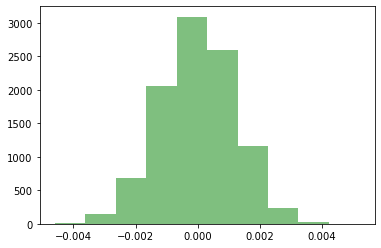

In [34]:
# Plot the null distribution
plt.hist(p_diffs,alpha=0.5, color='green');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

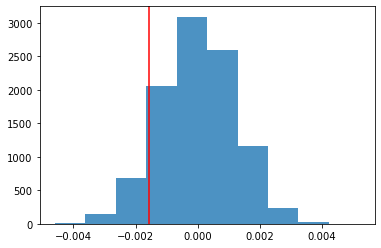

In [35]:
obs = prob_of_original_treatment - prob_of_original_control
plt.hist(p_diffs,alpha=0.8);
plt.axvline(obs,color= 'r');

In [36]:
upper = (p_diffs > p_diffs.mean() + (p_diffs.mean() - obs)).mean()
lower = (p_diffs < obs).mean()
p_value = (p_diffs > obs).mean()
print("The p-value is: "+ str(p_value))

The p-value is: 0.9046


****

**Here I have simulated the null hypostasis and placed the statistic value after that I measured the p-value which i the probability of observing the statistic or more values in favor of the alternative hypostasis and we set our threshold of rejecting the null to be .05 since our p-value is .9076 we can not reject the null so we stick to it as there is not significant evidence that the new page performs better than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0


In [38]:
df2.query("group == 'control'").converted.sum()

17489

In [39]:
df2.query("group == 'control' and converted == 1").shape[0]

17489

In [40]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control' and converted == 1").shape[0]
convert_new = df2.query("group == 'treatment' and converted == 1").shape[0]
n_old = n_old 
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [41]:
import statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [42]:
counts = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = proportions_ztest(counts, nobs, alternative='smaller')
print(stat, pval)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

the z score means that our obs is 1.3109 standard deviation above the mean 

the p-value is the same as previous

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, the type of regression should be performed in this case is **logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
df2['intercept'] = 1

In [44]:
df2[['new_page' , 'old_page']] = pd.get_dummies(df.landing_page)

In [45]:
df2[['z' , 'ab_page']] = pd.get_dummies(df.group)

In [46]:
df2.drop('z',axis=1,inplace=True)

In [47]:
df2

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,1,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [48]:
lm = sm.Logit(df2.converted, df2[['intercept','ab_page']])
response = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [49]:
response.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-10-04 18:38 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 



**The p-value associated with ab_page is 0.1899 which didn't reach the threshold of .05 so there is still no evidence that the new page is better than the old page**

**The p-value is higher than the previous one and that's because it is a two-sided test but the previous p-value was calculated from a one-sided test** 

**The one-tailed test in this case looks if the new page doing better than the old page or not**

   ######                     <span style="color:white">asdasdasdasdasdadasasdasdasdasdasdsadasdsadasdasdas</span>              **$H_0$** = **$p_{new}$** - **$p_{old}$** **$\le$** 0
 
   ######                            <span style="color:white">asdasdasdasdasdadasasdasdasdasdasdsadasdsadasdasdas</span>           **$H_1$** = **$p_{new}$** - **$p_{old}$** **$>$** 0


**On the other hand, a two-tailed test in this case looks if the new page differs from the old page or not whether a positive or negative change.**


   ######                     <span style="color:white">asdasdasdasdasdasdadsdasdasdasdasdsadasdsadasdasdas</span>                  **$H_0$** = **$p_{new}$** - **$p_{old}$** **$=$** 0
 
   ######                    <span style="color:white">asdasdasdasdasdasdadadasdasdasdasdsadasdsadasdasdas</span>                   **$H_1$** = **$p_{new}$** - **$p_{old}$** **$\neq$** 0

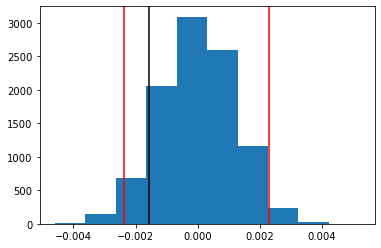

In [50]:
# to make a comparison to the previous part, having a two-tailed test there would mean that we would reject the null 
# if the observed conversion difference is either lower than -0.0023 or higher than 0.0023
# we see that we are definitely somewhat closer to the rejection region (i.e. there is also a lower p-value) in this case 
# than we were in the one-tailed case
plt.hist(p_diffs)
plt.axvline(x=obs, color='black')
plt.axvline(x=np.percentile(p_diffs, 2.5), color='REd')
plt.axvline(x=np.percentile(p_diffs, 97.5), color='red');

In [51]:
print('2.5th percentile:', np.percentile(p_diffs, 2.5))
print('97.5th percentile:', np.percentile(p_diffs, 97.5))

2.5th percentile: -0.002382928557982927
97.5th percentile: 0.002286380859872641


In [52]:
upper = (p_diffs < obs).mean()
print("upper : "+str(upper))
lower = (p_diffs > p_diffs.mean()+(p_diffs.mean()-obs)).mean()
print("lower : "+str(lower))
print("upper + lower (p-value) : "+str(upper+lower))

upper : 0.0954
lower : 0.0957
upper + lower (p-value) : 0.1911


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?



**Additional terms into regression model.**

Adding additional factors to a regression model can be a good idea because it allows you to capture more complexity and potentially improve the model's predictive power. By including more relevant factors, you can account for additional sources of variation and better explain the relationship between the independent variables and the dependent variable.

However, there are a few potential disadvantages to consider when adding additional terms to a regression model:

1- Overfitting

2- Multicollinearity

3- Increased complexity

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  Provide the statistical output as well as a written response to answer this question.

In [53]:
df_cont = pd.read_csv('countries.csv')
df_cont[df_cont['user_id'] == 839785]

,user_id,country
162575,839785,CA


In [54]:
df2 = df2.join(df_cont.set_index('user_id'), on='user_id')

In [55]:
df2[['CA','UK','US']] = pd.get_dummies(df2.country)

In [56]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA,1,0,0


In [57]:
lm = sm.Logit(df2.converted, df2[['intercept','CA','UK']])
response = lm.fit()
response.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2023-10-04 18:38 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

**Asnwer** it does not appear that country has an impact on conversion (the p-value associated with it is high enough to reject the alternative)

In [58]:
lm = sm.Logit(df2.converted, df2[['intercept','ab_page','CA','UK']])
response = lm.fit()
response.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2023-10-04 18:38 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**Adding ab_page to the model makes no difference**, all variables are still insignificant and the null cannot be rejected.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [59]:
df2['CA_treat'] = df2.CA * df2.ab_page
df2['UK_treat'] = df2.UK * df2.ab_page
df2['US_treat'] = df2.US * df2.ab_page

In [60]:
sm.Logit(df2.converted, df2[['intercept', 'ab_page', 'CA', 'UK', 'CA_treat', 'UK_treat']])

In [61]:
lm = sm.Logit(df2.converted, df2[['intercept', 'ab_page', 'CA', 'UK', 'CA_treat', 'UK_treat']])
response = lm.fit()
response.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2023-10-04 18:38 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_treat     -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_treat      0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Adding an intersection column between country and page type does not seem to have an impact on the conversion rate.

### Exploring timestamp and its relation with conversion.

In [62]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2['day'] = df2.timestamp.dt.day
df2['day_name'] = df2.timestamp.dt.day_name()
df2['hour'] = df2.timestamp.dt.hour
df2['minute'] = df2.timestamp.dt.minute

In [63]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,CA_treat,UK_treat,US_treat,day,day_name,hour,minute
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0,1,11,Wednesday,16,55
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0,1,8,Sunday,18,28
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,1,0,0,1,0,0,19,Thursday,3,26
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK,0,1,0,0,1,0,4,Wednesday,17,58
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA,1,0,0,1,0,0,15,Sunday,18,11


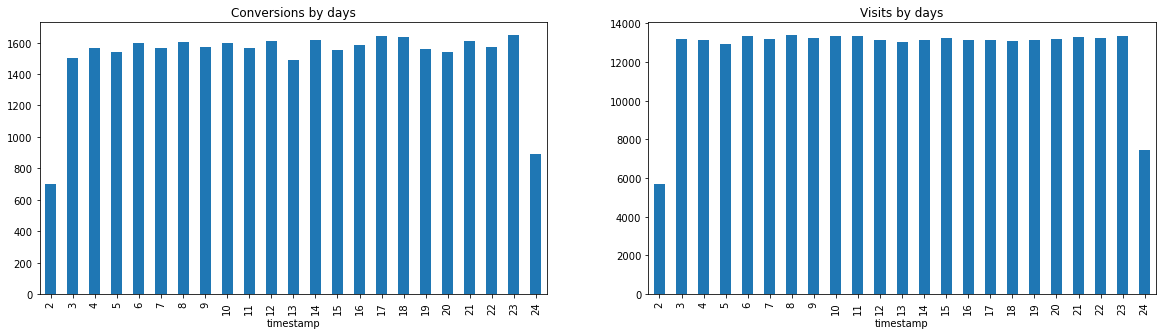

In [64]:

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
# conversion totals show little volatility between days, but no clear trend 
# (the first and the last day was not included as a whole)
g1 = df2.groupby(df2['timestamp'].dt.day).sum()['converted'].plot(kind="bar")
g1.set(title='Conversions by days')

plt.subplot(1,2,2)
# while traffic is almost the same every day
g2 = df2.groupby(df2['timestamp'].dt.day).count()['converted'].plot(kind="bar")
g2.set(title='Visits by days')

plt.show()

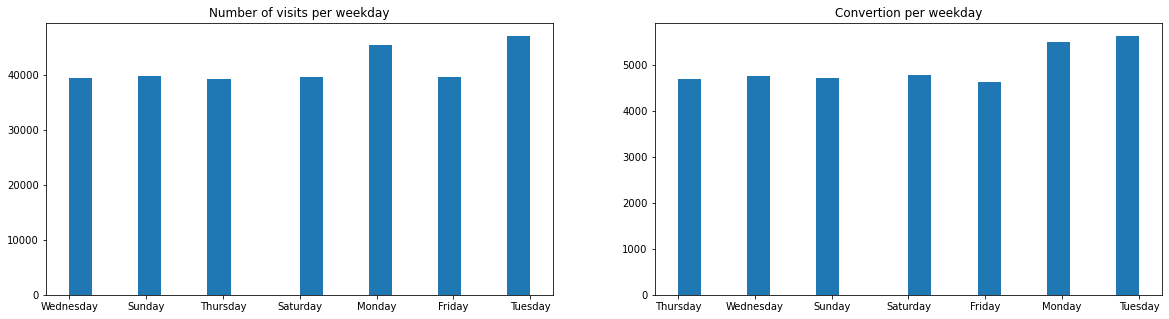

In [65]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(df2.day_name,bins = 20)
plt.title('Number of visits per weekday')
plt.subplot(1,2,2)
plt.hist(df2.query("converted == 1").day_name,bins = 20)
plt.title('Convertion per weekday');

By comparing the Number of visits per weekday and Conversion per weekday to see if there is a day where conversion occurs more often 
but it looks the same in pattern as the days with high visits have high conversion too. 

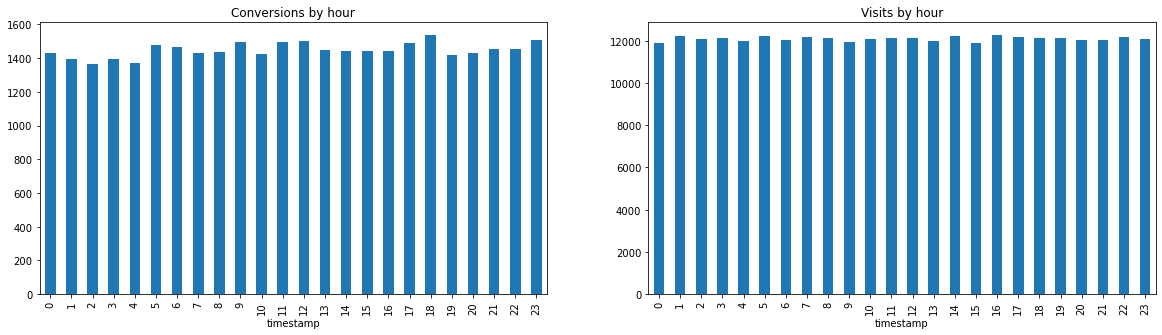

In [66]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
# conversions have a few peaks during the day
g5 = df2.groupby(df2['timestamp'].dt.hour).sum()['converted'].plot(kind="bar");
g5.set(title='Conversions by hour')

plt.subplot(1,2,2)
# while traffic is the same during the day
# it might be interesting to add this view to our model
g6 = df2.groupby(df2['timestamp'].dt.hour).count()['converted'].plot(kind="bar")
g6.set(title='Visits by hour')

plt.show()

In [68]:
# hour of the day groups to show that out of all information we have, hour of visiting the page might be the best 
# predictor of conversions
# let's create a few bucket not to have 24 dummies
df2['night'] = df2.apply(lambda row: 1 if (row.hour > 0 and row.hour < 5) else 0, axis=1)
df2['morning'] = df2.apply(lambda row: 1 if (row.hour >= 5 and row.hour < 9) else 0, axis=1)
df2['midday'] = df2.apply(lambda row: 1 if (row.hour >= 9 and row.hour < 13) else 0, axis=1)
df2['afternoon'] = df2.apply(lambda row: 1 if (row.hour >= 13 and row.hour < 17) else 0, axis=1)
df2['evening'] = df2.apply(lambda row: 1 if (row.hour >= 17 and row.hour < 21) else 0, axis=1)
df2['lateevening'] = df2.apply(lambda row: 1 if (row.hour >= 21 or row.hour == 0) else 0, axis=1)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,...,day,day_name,hour,minute,night,morning,midday,afternoon,evening,lateevening
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,...,11,Wednesday,16,55,0,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,...,8,Sunday,18,28,0,0,0,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,...,19,Thursday,3,26,1,0,0,0,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK,...,4,Wednesday,17,58,0,0,0,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA,...,15,Sunday,18,11,0,0,0,0,1,0


In [69]:
lm = sm.Logit(df2.converted, df2[['intercept', 'night', 'morning', 'midday', 'afternoon', 'evening']])
response = lm.fit()
response.summary2()

Optimization terminated successfully.
         Current function value: 0.366087
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212769.9269
Date:               2023-10-04 18:40 BIC:              212833.4048
No. Observations:   290584           Log-Likelihood:   -1.0638e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.0011754  
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9808    0.0140  -141.9832  0.0000  -2.0081  -1.9534
night        -0.0693    0.0200    -3.4681  0.0005  -0.1084  -0.0301
morning      -0.0158    0.0198    -0.7982  0.4248  -0.0545   0.0229
midday        0.0106    0.0197     0.5367  0.5915  -0.0280   0.0491
afternoon    -0.0184    0.0198    -0.9293  0.3527  -0.0571   0.0204
evening      -0.0014    0.0197    -0.0736  0.9413  -0.0401   0.0372
==================================================================

"""

In [70]:
lm = sm.Logit(df2.query("landing_page == 'new_page'").converted, df2.query("landing_page == 'new_page'")[['intercept', 'night', 'morning', 'midday', 'afternoon', 'evening']])
response = lm.fit()
response.summary2()

Optimization terminated successfully.
         Current function value: 0.364479
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              105936.9268
Date:               2023-10-04 18:40 BIC:              105996.2465
No. Observations:   145310           Log-Likelihood:   -52962.    
Df Model:           5                LL-Null:          -52972.    
Df Residuals:       145304           LLR p-value:      0.0022085  
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9834    0.0197  -100.4511  0.0000  -2.0221  -1.9447
night        -0.0889    0.0284    -3.1320  0.0017  -0.1445  -0.0333
morning      -0.0355    0.0281    -1.2621  0.2069  -0.0905   0.0196
midday       -0.0018    0.0279    -0.0643  0.9487  -0.0565   0.0529
afternoon    -0.0209    0.0280    -0.7470  0.4551  -0.0757   0.0339
evening       0.0221    0.0278     0.7949  0.4267  -0.0324   0.0766
==================================================================

"""

In [71]:
lm = sm.Logit(df2.query("landing_page == 'old_page'").converted, df2.query("landing_page == 'old_page'")[['intercept', 'night', 'morning', 'midday', 'afternoon', 'evening']])
response = lm.fit()
response.summary2()

Optimization terminated successfully.
         Current function value: 0.367666
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              106836.5317
Date:               2023-10-04 18:40 BIC:              106895.8499
No. Observations:   145274           Log-Likelihood:   -53412.    
Df Model:           5                LL-Null:          -53416.    
Df Residuals:       145268           LLR p-value:      0.14473    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9782    0.0197  -100.3433  0.0000  -2.0168  -1.9395
night        -0.0500    0.0281    -1.7786  0.0753  -0.1051   0.0051
morning       0.0034    0.0278     0.1213  0.9034  -0.0511   0.0578
midday        0.0229    0.0278     0.8237  0.4101  -0.0316   0.0773
afternoon    -0.0158    0.0280    -0.5659  0.5715  -0.0706   0.0390
evening      -0.0251    0.0279    -0.8996  0.3684  -0.0799   0.0296
==================================================================

"""

In [72]:
response.params

intercept   -1.978160
night       -0.050007
morning      0.003370
midday       0.022869
afternoon   -0.015828
evening     -0.025127
dtype: float64

### Model diagnostics

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [78]:
# fitting the model using sklearn
# coefficients are slightly different than using sm because sklearn is more focused on correct predictions than coefficients
# intercept is added automatically
X = df2[['ab_page', 'UK', 'CA', 'UK_treat', 'CA_treat', 'night', 'morning', 'midday', 'afternoon', 'lateevening']]
y = df2['converted']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .20,random_state=0)
# coefficients of the train model
log_mod7 = LogisticRegression()
log_mod7.fit(X_train, y_train)
preds = log_mod7.predict(X_test)
print(log_mod7.intercept_)
print(log_mod7.coef_)

[-1.98385161]
[[-0.01591404  0.01050229 -0.01466879  0.03206049 -0.0263722  -0.06387144
  -0.01761159  0.01572729 -0.00875633  0.00810248]]


In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)*100

87.9949068258857

- High accuracy but that does not mean a good predictive model

In [79]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
cm

array([[51140,     0],
       [ 6977,     0]], dtype=int64)

In [80]:
print('TN = 51140, FP = 0\nFN = 6977, TP = 0')

TN = 51140, FP = 0
FN = 6977, TP = 0


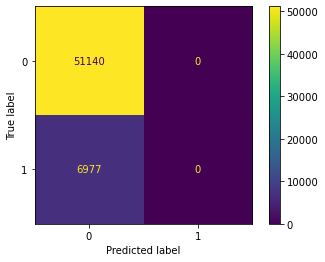

In [86]:
# Thre result of Confusion Matrix displayed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=log_mod7.classes_)
disp.plot()

plt.show()

In [84]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, preds)

0.0

- Our model did not predict any convention value and this is an indication of a bad model we can see that from the 
F1 score we calculated as it is equal to Zero. 

In [93]:
df2.query("converted == 1").shape[0]/ df2.shape[0]*100

11.959708724499627

**The model classifies all values as 0 (not converted) as it gives high accuracy as only 12% of the visitors in data have converted**

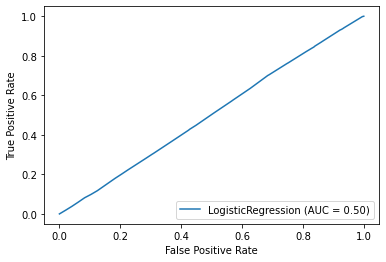

In [100]:
# Plot Roc Curve
from sklearn import metrics
metrics.plot_roc_curve(log_mod7, X_test, y_test) 
plt.show()

## Conclusions
- In conclusion, there is not enough evidence that the new_page increases the conversion rate as compared to the old_page. This is based on the probability figures, A/B test, and regression. There is no strong evidence that the countries (US, CA, and UK) influence the conversion rate.

- Since the sample size is large and the p-value is far from .05 continuing the testing of the new_page is not necessary and will not come with new outcomes.
- So we recommend looking for another approach to develop the experience of the visitor and increase the conversion rate.

In [102]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1